In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import sklearn
import os

In [2]:
DATA_DIR = "./raw_data_2010_2023/"

In [3]:
drop = [ 'SLC','CWA','MEM', 'BTV']

In [4]:
def find_csv_files(folder_path, suffix=".csv"):
    """
    Find all CSV files in the given folder path.

    Args:
    - folder_path (str): Path to the folder where CSV files are located.
    - suffix (str): Suffix to filter files (default is '.csv').

    Returns:
    - list: List of CSV files with the given suffix.
    """
    csv_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(suffix):
                csv_files.append(os.path.join(root, file))
    return csv_files

In [5]:
def plot_top_n_categorical(data, column, n=None, figsize=(15, 5)):
    """
    Plot the distribution of the top N categories of a categorical variable.

    Args:
    - data (pandas DataFrame): DataFrame containing the categorical variable.
    - column (str): Name of the categorical variable column.
    - n (int or None): Number of top categories to plot. If None, plot all categories (default is None).
    - figsize (tuple): Width and height of the figure in inches (default is (10, 6)).

    Returns:
    - None (displays the plot).
    """
    if n is None:
        categories = data[column].value_counts().index
    else:
        categories = data[column].value_counts().nlargest(n).index
        
    data_filtered = data[data[column].isin(categories)]
    
    plt.figure(figsize=figsize)
    sns.countplot(data=data_filtered, x=column, order=categories)
    plt.title(f'Top {len(categories)} Categories of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()


In [6]:
all_data_files = find_csv_files(DATA_DIR, suffix="_cleaned.csv")

In [7]:
all_dfs = []
for f in all_data_files:
    all_dfs.append(pd.read_csv(f, parse_dates=["Date (MM/DD/YYYY)"]))

In [8]:
all_merged = pd.concat(all_dfs, ignore_index=True)

In [9]:
all_merged.head()

,Carrier Code,Date (MM/DD/YYYY),Flight Number,Tail Number,Origin Airport,Scheduled Arrival Time,Actual Arrival Time,Scheduled Elapsed Time (Minutes),Actual Elapsed Time (Minutes),Arrival Delay (Minutes),Wheels-on Time,Taxi-In time (Minutes),Delay Carrier (Minutes),Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes)
0,B6,2010-01-01,22,N608JB,JFK,00:01,02:41,76,72,160,02:37,4,160,0,0,0,0
1,B6,2010-01-01,42,N586JB,JFK,11:52,13:05,71,78,73,12:59,6,66,0,7,0,0
2,B6,2010-01-01,44,N586JB,JFK,08:55,09:11,75,60,16,09:09,2,16,0,0,0,0
3,B6,2010-01-01,62,N284JB,JFK,16:23,16:21,84,60,-2,16:17,4,0,0,0,0,0
4,B6,2010-01-01,660,N653JB,MCO,20:48,20:49,158,148,1,20:47,2,0,0,0,0,0


In [10]:
sorted_all_merged = all_merged.sort_values(by=['Date (MM/DD/YYYY)', 'Scheduled Arrival Time']).reset_index(drop=True)

In [11]:
sorted_all_merged = sorted_all_merged.drop_duplicates().reset_index(drop=True)

In [12]:
sorted_all_merged.shape

(113675, 17)

In [13]:
sorted_all_merged = sorted_all_merged[~sorted_all_merged['Origin Airport'].isin(drop)]

In [14]:
sorted_all_merged.shape

(113671, 17)

# CARRIER CODE

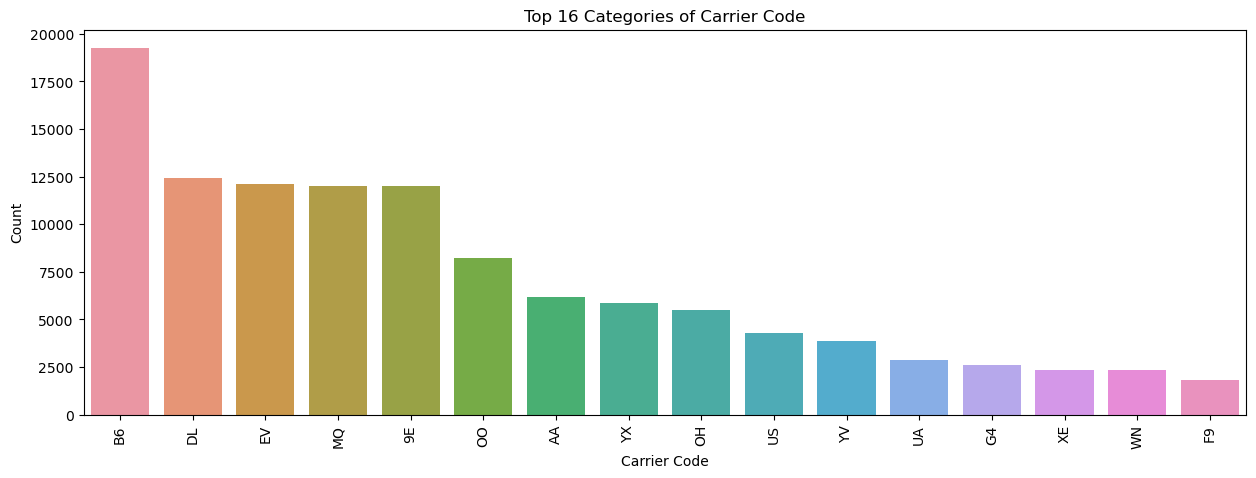

In [15]:
plot_top_n_categorical(sorted_all_merged, "Carrier Code")

# FLIGHT NUMBER

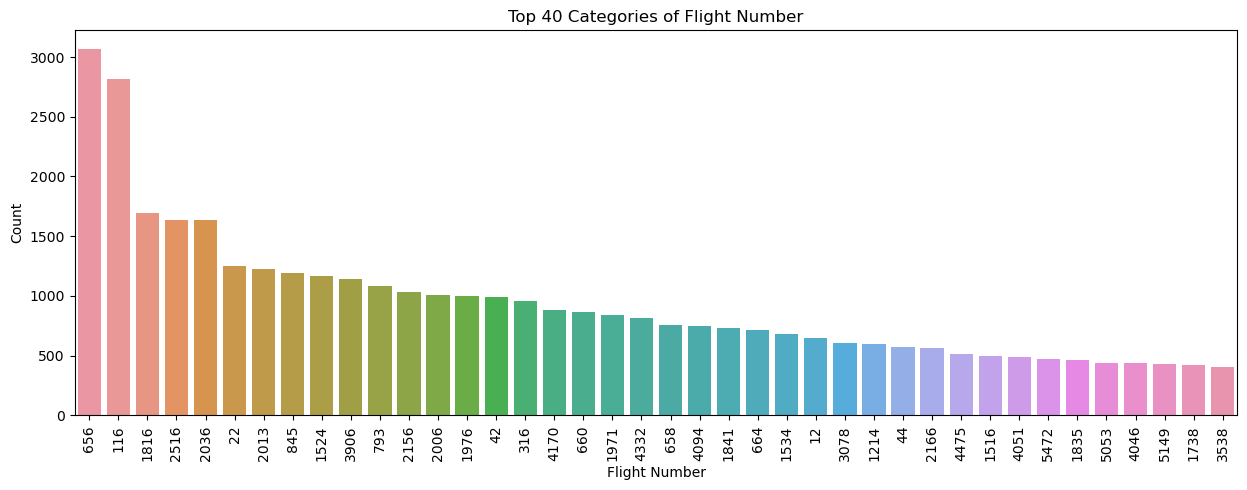

In [16]:
plot_top_n_categorical(sorted_all_merged, "Flight Number", 40)

# TAIL NUMBER

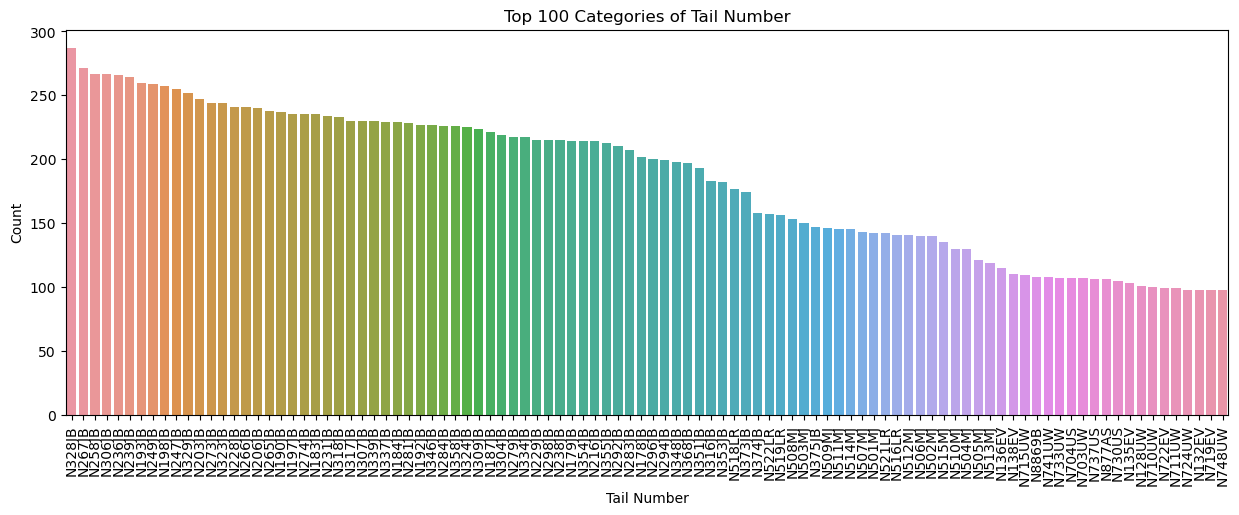

In [17]:
plot_top_n_categorical(sorted_all_merged, 'Tail Number', 100)

# ORIGIN AIRPORT

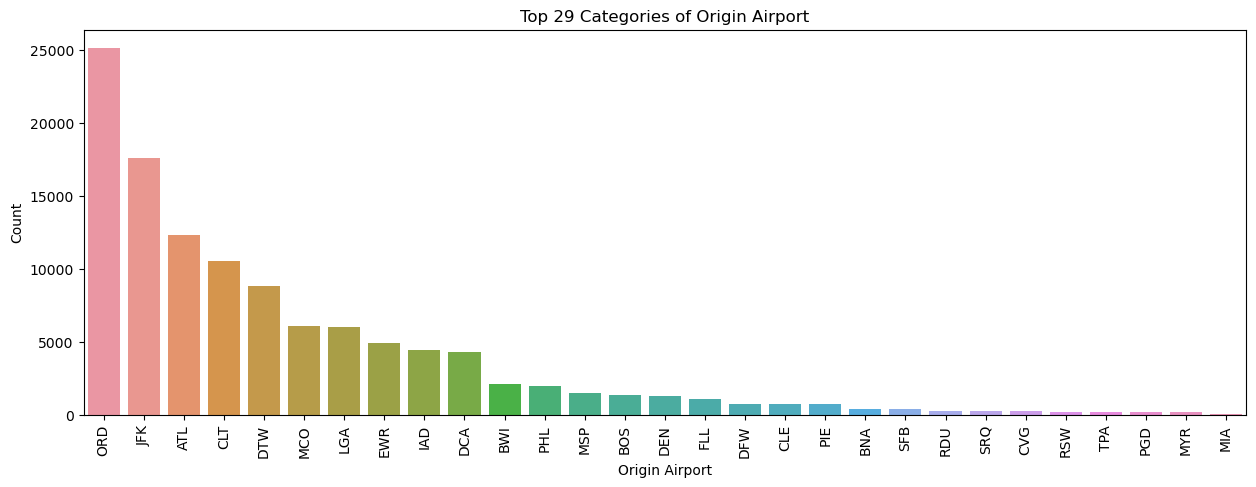

In [18]:
plot_top_n_categorical(sorted_all_merged, 'Origin Airport')

# COLUMNS

In [19]:
sorted_all_merged.columns

Index(['Carrier Code', 'Date (MM/DD/YYYY)', 'Flight Number', 'Tail Number',
       'Origin Airport', 'Scheduled Arrival Time', 'Actual Arrival Time',
       'Scheduled Elapsed Time (Minutes)', 'Actual Elapsed Time (Minutes)',
       'Arrival Delay (Minutes)', 'Wheels-on Time', 'Taxi-In time (Minutes)',
       'Delay Carrier (Minutes)', 'Delay Weather (Minutes)',
       'Delay National Aviation System (Minutes)', 'Delay Security (Minutes)',
       'Delay Late Aircraft Arrival (Minutes)'],
      dtype='object')

In [20]:
to_drop = ['Wheels-on Time', 'Taxi-In time (Minutes)',
       'Delay Carrier (Minutes)', 'Delay Weather (Minutes)',
       'Delay National Aviation System (Minutes)', 'Delay Security (Minutes)',
       'Delay Late Aircraft Arrival (Minutes)']

In [21]:
def date_to_season(date):
    """
    Determine the season for a given date without considering the year.

    Parameters:
    date (Timestamp): The date.

    Returns:
    str: The season corresponding to the given date.
    """
    # Define fixed date ranges for each season
    seasons = {
        'winter': ((1, 1), (3, 20)),
        'spring': ((3, 21), (6, 20)),
        'summer': ((6, 21), (9, 22)),
        'autumn': ((9, 23), (12, 20)),
        'winter': ((12, 21), (12, 31)),
        'winter': ((1, 1), (1, 31))
    }

    # Get month and day from the date
    month = date.month
    day = date.day
    print(date.year, date.month, date.day)
    # Determine the season based on the month and day
    for season, (start_md, end_md) in seasons.items():
        if start_md <= (month, day) <= end_md:
            return season

In [22]:
def create_categorical_column(df):
    """
    Create a categorical column in the DataFrame based on the range of a numeric column by iterating over each row.

    Parameters:
    df (DataFrame): The pandas DataFrame.
    numeric_column (str): The name of the numeric column.

    Returns:
    DataFrame: The DataFrame with the new categorical column.
    """
    numeric_column = 'Arrival Delay (Minutes)'
    categorical_values = []
    for index, row in df.iterrows():
        numeric_value = row[numeric_column]
        # Customize the conditions based on your requirement
        if abs(numeric_value) <= 5:
            categorical_values.append('ONTIME')
        elif numeric_value < -5:
            categorical_values.append('EARLY')
        elif numeric_value > 5:
            categorical_values.append('LATE')
        else:
            print("THIS SHOULDN't HAPPEN")
    df['FLIGHT_STATUS'] = categorical_values
    return df

In [23]:
processed = sorted_all_merged.drop(columns=to_drop)

In [24]:
processed = create_categorical_column(processed)

In [25]:
processed = processed.drop(columns=[ 'Actual Elapsed Time (Minutes)', 'Actual Arrival Time'])

In [26]:
def month_to_season(month):
    """
    Determine the season for a given month.

    Parameters:
    month (int): The month number (1-12).

    Returns:
    str: The season corresponding to the given month.
    """
    # Define mapping of months to seasons
    season_map = {
        1: 'winter',
        2: 'winter',
        3: 'spring',
        4: 'spring',
        5: 'spring',
        6: 'summer',
        7: 'summer',
        8: 'summer',
        9: 'autumn',
        10: 'autumn',
        11: 'autumn',
        12: 'winter'
    }
    
    return season_map.get(month, 'Unknown')

In [27]:
processed['month'] = processed['Date (MM/DD/YYYY)'].dt.month

In [28]:
processed['day'] = processed['Date (MM/DD/YYYY)'].dt.day

In [29]:
processed['season'] = processed['month'].apply(month_to_season)

In [31]:
processed['WeekDay'] = processed['Date (MM/DD/YYYY)'].dt.day_name()

In [ ]:
# processed.to_csv("./INITIAL_PROCESSED_DATA_NUMERIC.csv", index=False)

In [32]:
processed.head()

,Carrier Code,Date (MM/DD/YYYY),Flight Number,Tail Number,Origin Airport,Scheduled Arrival Time,Scheduled Elapsed Time (Minutes),Arrival Delay (Minutes),FLIGHT_STATUS,month,day,season,WeekDay
0,B6,2010-01-01,22,N608JB,JFK,00:01,76,160,LATE,1,1,winter,Friday
1,B6,2010-01-01,44,N586JB,JFK,08:55,75,16,LATE,1,1,winter,Friday
2,MQ,2010-01-01,4094,N610MQ,ORD,11:20,100,4,ONTIME,1,1,winter,Friday
3,9E,2010-01-01,3818,89289E,DTW,11:44,84,22,LATE,1,1,winter,Friday
4,B6,2010-01-01,42,N586JB,JFK,11:52,71,73,LATE,1,1,winter,Friday


# DATA PREP FOR 2nd Model

In [ ]:
processed.sort_values(by=['Date (MM/DD/YYYY)', 'Scheduled Arrival Time'])

In [ ]:
def create_data_2nd_model_data(df, prev_status='ONTIME'):
    prevStatus = []
    for index, row in df.iterrows():
        prevStatus.append(prev_status)
        prev_status = row['FLIGHT_STATUS']
    df['PREV_STAT'] = pd.Series(prevStatus)
    return df

In [ ]:
def create_data_2nd_model_data_ext(df, num_prev=3):
    extended_data = []
    for index, row in df.iterrows():
        for i in range(num_prev):
            if index - i - 1 >= 0:
                extended_row = row.copy()  # Create a copy of the current row
                extended_row['PREV_STAT'] = df.iloc[index - i - 1]['FLIGHT_STATUS']
                extended_data.append(extended_row)
            else:
                extended_row = row.copy()  # Create a copy of the current row
                extended_row['PREV_STAT'] = 'ONTIME'
                extended_data.append(extended_row)
    df_extended = pd.DataFrame(extended_data)
    return df_extended.reset_index(drop=True)


In [ ]:
final_data = processed.drop(columns=['Arrival Delay (Minutes)'])

In [ ]:
final_data.head()

In [ ]:
# create_data_2nd_model_data(final_data).to_csv("1_HOP.csv", index=False)

In [ ]:
# create_data_2nd_model_data_ext(final_data).to_csv("3_HOP.csv", index=False)

In [57]:
airport_to_csv_mapping = {
#     'ORD': '72530094846.csv', 
#     'JFK': '74486094789.csv', 
#     'ATL': '72219013874.csv', 
#     'CLT': '72314013881.csv', 
#     'DTW': '72537094847.csv', 
#     'MCO': '72205012815.csv', 
#     'LGA': '72503014732.csv', 
#     'EWR': '72502014734.csv', 
#     'IAD': '72403093738.csv', 
#     'SYR':'72519014771.csv',
#     'DCA': '72405013743.csv', 
#     'BWI': '72406093721.csv', 
#     'PHL': '72408013739.csv', 
#     'MSP': '72658014922.csv', 
#     'BOS': '72509014739.csv', 
    'DEN': '72565003017.csv', 
    'FLL': '74783012849.csv', 
    'DFW': '72259303985.csv', 
    'CLE': '72524014820.csv', 
    'PIE': '72211612873.csv', 
    'BNA': '72327013897.csv', 
    'SFB': '72205712854.csv', 
    'RDU': '72306013722.csv', 
    'SRQ': '72211512871.csv', 
    'CVG': '72421093814.csv', 
    'RSW': '72210812894.csv',
    'TPA': '72211012842.csv', 
    'PGD': '72203412812.csv', 
    'MYR': '74791013717.csv', 
    'MIA': '72202012839.csv',
}

In [58]:
# import os
# import urllib.request

# WEATHER_REPO = './weather/'
# years = list(range(2010, 2023))
# BASE_LINK = 'https://www.ncei.noaa.gov/data/global-hourly/access/'
# airports = airport_to_csv_mapping.keys()

# for ap in airports:
#     apdir = os.path.join(WEATHER_REPO, ap)  # Create directory path for each airport
#     os.makedirs(apdir, exist_ok=True)  # Create directory if it doesn't exist
#     for y in years:
#         file_url = BASE_LINK + str(y) + "/" + airport_to_csv_mapping[ap]
#         file_name = os.path.basename(file_url)  # Extract filename from URL
#         # Add year to the filename
#         file_name_with_year = str(y) + "_" + file_name
#         file_path = os.path.join(apdir, file_name_with_year)  # Create full file path
#         urllib.request.urlretrieve(file_url, file_path)  # Download file into correct directory
#         print("Downloaded:", file_name_with_year, "into", apdir)


In [59]:
columns_to_consider = ["STATION","DATE","SOURCE","LATITUDE","LONGITUDE","ELEVATION","NAME",
                       "REPORT_TYPE","CALL_SIGN","QUALITY_CONTROL","WND","CIG","VIS","TMP","DEW","SLP"]


In [60]:
import os
import pandas as pd
import urllib.request

WEATHER_REPO = './weather/'
years = list(range(2010, 2024))
BASE_LINK = 'https://www.ncei.noaa.gov/data/global-hourly/access/'
airports = airport_to_csv_mapping.keys()

# Specify columns you want to consider
columns_to_consider = ["STATION","DATE","SOURCE","LATITUDE","LONGITUDE","ELEVATION","NAME",
                       "REPORT_TYPE","CALL_SIGN","QUALITY_CONTROL","WND","CIG","VIS","TMP","DEW","SLP"]


# Dictionary to store DataFrame for each airport
airport_dfs = {}

for ap in airports:
    # List to store DataFrames for each year
    dfs_per_year = []
    
    for y in years:
        try:
            file_url = BASE_LINK + str(y) + "/" + airport_to_csv_mapping[ap]
            # Read only specific columns from CSV data directly from URL into DataFrame
            df = pd.read_csv(file_url, usecols=columns_to_consider)
            # Append DataFrame to list
            dfs_per_year.append(df)
            print(ap, file_url)
        except Exception as e:
            print(e)
            print(ap, file_url)

    # Concatenate DataFrames for each year into a single DataFrame
    airport_df = pd.concat(dfs_per_year, ignore_index=True)
    # Store DataFrame in dictionary
    airport_dfs[ap] = airport_df

    # Save the concatenated DataFrame to a CSV file in the weather repository
    file_name = os.path.join(WEATHER_REPO, f"{ap}_weather_data.csv")
    airport_df.to_csv(file_name, index=False)

# Access DataFrame for a specific airport
# For example, to access DataFrame for airport 'JFK':
# jfk_df = airport_dfs['JFK']


DEN https://www.ncei.noaa.gov/data/global-hourly/access/2010/72565003017.csv
DEN https://www.ncei.noaa.gov/data/global-hourly/access/2011/72565003017.csv
DEN https://www.ncei.noaa.gov/data/global-hourly/access/2012/72565003017.csv
HTTP Error 404: Not Found
DEN https://www.ncei.noaa.gov/data/global-hourly/access/2013/72565003017.csv
DEN https://www.ncei.noaa.gov/data/global-hourly/access/2014/72565003017.csv
DEN https://www.ncei.noaa.gov/data/global-hourly/access/2015/72565003017.csv
DEN https://www.ncei.noaa.gov/data/global-hourly/access/2016/72565003017.csv
DEN https://www.ncei.noaa.gov/data/global-hourly/access/2017/72565003017.csv
DEN https://www.ncei.noaa.gov/data/global-hourly/access/2018/72565003017.csv
DEN https://www.ncei.noaa.gov/data/global-hourly/access/2019/72565003017.csv
DEN https://www.ncei.noaa.gov/data/global-hourly/access/2020/72565003017.csv
DEN https://www.ncei.noaa.gov/data/global-hourly/access/2021/72565003017.csv
DEN https://www.ncei.noaa.gov/data/global-hourly/a

/tmp/ipykernel_2379591/3100021501.py:26: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_url, usecols=columns_to_consider)


FLL https://www.ncei.noaa.gov/data/global-hourly/access/2010/74783012849.csv
FLL https://www.ncei.noaa.gov/data/global-hourly/access/2011/74783012849.csv
FLL https://www.ncei.noaa.gov/data/global-hourly/access/2012/74783012849.csv
FLL https://www.ncei.noaa.gov/data/global-hourly/access/2013/74783012849.csv
FLL https://www.ncei.noaa.gov/data/global-hourly/access/2014/74783012849.csv
FLL https://www.ncei.noaa.gov/data/global-hourly/access/2015/74783012849.csv
FLL https://www.ncei.noaa.gov/data/global-hourly/access/2016/74783012849.csv
FLL https://www.ncei.noaa.gov/data/global-hourly/access/2017/74783012849.csv
FLL https://www.ncei.noaa.gov/data/global-hourly/access/2018/74783012849.csv
FLL https://www.ncei.noaa.gov/data/global-hourly/access/2019/74783012849.csv
FLL https://www.ncei.noaa.gov/data/global-hourly/access/2020/74783012849.csv
FLL https://www.ncei.noaa.gov/data/global-hourly/access/2021/74783012849.csv
FLL https://www.ncei.noaa.gov/data/global-hourly/access/2022/74783012849.csv

/tmp/ipykernel_2379591/3100021501.py:26: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_url, usecols=columns_to_consider)


DFW https://www.ncei.noaa.gov/data/global-hourly/access/2022/72259303985.csv
DFW https://www.ncei.noaa.gov/data/global-hourly/access/2023/72259303985.csv
CLE https://www.ncei.noaa.gov/data/global-hourly/access/2010/72524014820.csv
CLE https://www.ncei.noaa.gov/data/global-hourly/access/2011/72524014820.csv
CLE https://www.ncei.noaa.gov/data/global-hourly/access/2012/72524014820.csv
CLE https://www.ncei.noaa.gov/data/global-hourly/access/2013/72524014820.csv
CLE https://www.ncei.noaa.gov/data/global-hourly/access/2014/72524014820.csv
CLE https://www.ncei.noaa.gov/data/global-hourly/access/2015/72524014820.csv
CLE https://www.ncei.noaa.gov/data/global-hourly/access/2016/72524014820.csv
CLE https://www.ncei.noaa.gov/data/global-hourly/access/2017/72524014820.csv
CLE https://www.ncei.noaa.gov/data/global-hourly/access/2018/72524014820.csv
CLE https://www.ncei.noaa.gov/data/global-hourly/access/2019/72524014820.csv
CLE https://www.ncei.noaa.gov/data/global-hourly/access/2020/72524014820.csv

/tmp/ipykernel_2379591/3100021501.py:26: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_url, usecols=columns_to_consider)


PIE https://www.ncei.noaa.gov/data/global-hourly/access/2012/72211612873.csv
PIE https://www.ncei.noaa.gov/data/global-hourly/access/2013/72211612873.csv
PIE https://www.ncei.noaa.gov/data/global-hourly/access/2014/72211612873.csv
PIE https://www.ncei.noaa.gov/data/global-hourly/access/2015/72211612873.csv
PIE https://www.ncei.noaa.gov/data/global-hourly/access/2016/72211612873.csv
PIE https://www.ncei.noaa.gov/data/global-hourly/access/2017/72211612873.csv


/tmp/ipykernel_2379591/3100021501.py:26: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_url, usecols=columns_to_consider)


PIE https://www.ncei.noaa.gov/data/global-hourly/access/2018/72211612873.csv
PIE https://www.ncei.noaa.gov/data/global-hourly/access/2019/72211612873.csv
PIE https://www.ncei.noaa.gov/data/global-hourly/access/2020/72211612873.csv
PIE https://www.ncei.noaa.gov/data/global-hourly/access/2021/72211612873.csv
PIE https://www.ncei.noaa.gov/data/global-hourly/access/2022/72211612873.csv
PIE https://www.ncei.noaa.gov/data/global-hourly/access/2023/72211612873.csv
BNA https://www.ncei.noaa.gov/data/global-hourly/access/2010/72327013897.csv
BNA https://www.ncei.noaa.gov/data/global-hourly/access/2011/72327013897.csv
BNA https://www.ncei.noaa.gov/data/global-hourly/access/2012/72327013897.csv
BNA https://www.ncei.noaa.gov/data/global-hourly/access/2013/72327013897.csv
BNA https://www.ncei.noaa.gov/data/global-hourly/access/2014/72327013897.csv
BNA https://www.ncei.noaa.gov/data/global-hourly/access/2015/72327013897.csv
BNA https://www.ncei.noaa.gov/data/global-hourly/access/2016/72327013897.csv

/tmp/ipykernel_2379591/3100021501.py:26: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_url, usecols=columns_to_consider)


SFB https://www.ncei.noaa.gov/data/global-hourly/access/2012/72205712854.csv
SFB https://www.ncei.noaa.gov/data/global-hourly/access/2013/72205712854.csv
SFB https://www.ncei.noaa.gov/data/global-hourly/access/2014/72205712854.csv
SFB https://www.ncei.noaa.gov/data/global-hourly/access/2015/72205712854.csv
SFB https://www.ncei.noaa.gov/data/global-hourly/access/2016/72205712854.csv
SFB https://www.ncei.noaa.gov/data/global-hourly/access/2017/72205712854.csv
SFB https://www.ncei.noaa.gov/data/global-hourly/access/2018/72205712854.csv
SFB https://www.ncei.noaa.gov/data/global-hourly/access/2019/72205712854.csv
SFB https://www.ncei.noaa.gov/data/global-hourly/access/2020/72205712854.csv
SFB https://www.ncei.noaa.gov/data/global-hourly/access/2021/72205712854.csv
SFB https://www.ncei.noaa.gov/data/global-hourly/access/2022/72205712854.csv
SFB https://www.ncei.noaa.gov/data/global-hourly/access/2023/72205712854.csv
RDU https://www.ncei.noaa.gov/data/global-hourly/access/2010/72306013722.csv

/tmp/ipykernel_2379591/3100021501.py:26: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_url, usecols=columns_to_consider)


SRQ https://www.ncei.noaa.gov/data/global-hourly/access/2012/72211512871.csv
SRQ https://www.ncei.noaa.gov/data/global-hourly/access/2013/72211512871.csv
SRQ https://www.ncei.noaa.gov/data/global-hourly/access/2014/72211512871.csv
SRQ https://www.ncei.noaa.gov/data/global-hourly/access/2015/72211512871.csv
SRQ https://www.ncei.noaa.gov/data/global-hourly/access/2016/72211512871.csv
SRQ https://www.ncei.noaa.gov/data/global-hourly/access/2017/72211512871.csv
SRQ https://www.ncei.noaa.gov/data/global-hourly/access/2018/72211512871.csv
SRQ https://www.ncei.noaa.gov/data/global-hourly/access/2019/72211512871.csv
SRQ https://www.ncei.noaa.gov/data/global-hourly/access/2020/72211512871.csv
SRQ https://www.ncei.noaa.gov/data/global-hourly/access/2021/72211512871.csv
SRQ https://www.ncei.noaa.gov/data/global-hourly/access/2022/72211512871.csv
SRQ https://www.ncei.noaa.gov/data/global-hourly/access/2023/72211512871.csv
CVG https://www.ncei.noaa.gov/data/global-hourly/access/2010/72421093814.csv

/tmp/ipykernel_2379591/3100021501.py:26: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_url, usecols=columns_to_consider)


RSW https://www.ncei.noaa.gov/data/global-hourly/access/2012/72210812894.csv
RSW https://www.ncei.noaa.gov/data/global-hourly/access/2013/72210812894.csv
RSW https://www.ncei.noaa.gov/data/global-hourly/access/2014/72210812894.csv
RSW https://www.ncei.noaa.gov/data/global-hourly/access/2015/72210812894.csv
RSW https://www.ncei.noaa.gov/data/global-hourly/access/2016/72210812894.csv
RSW https://www.ncei.noaa.gov/data/global-hourly/access/2017/72210812894.csv
RSW https://www.ncei.noaa.gov/data/global-hourly/access/2018/72210812894.csv
RSW https://www.ncei.noaa.gov/data/global-hourly/access/2019/72210812894.csv
RSW https://www.ncei.noaa.gov/data/global-hourly/access/2020/72210812894.csv
RSW https://www.ncei.noaa.gov/data/global-hourly/access/2021/72210812894.csv
RSW https://www.ncei.noaa.gov/data/global-hourly/access/2022/72210812894.csv
RSW https://www.ncei.noaa.gov/data/global-hourly/access/2023/72210812894.csv
TPA https://www.ncei.noaa.gov/data/global-hourly/access/2010/72211012842.csv

/tmp/ipykernel_2379591/3100021501.py:26: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_url, usecols=columns_to_consider)


PGD https://www.ncei.noaa.gov/data/global-hourly/access/2012/72203412812.csv
PGD https://www.ncei.noaa.gov/data/global-hourly/access/2013/72203412812.csv
PGD https://www.ncei.noaa.gov/data/global-hourly/access/2014/72203412812.csv
PGD https://www.ncei.noaa.gov/data/global-hourly/access/2015/72203412812.csv
PGD https://www.ncei.noaa.gov/data/global-hourly/access/2016/72203412812.csv
PGD https://www.ncei.noaa.gov/data/global-hourly/access/2017/72203412812.csv


/tmp/ipykernel_2379591/3100021501.py:26: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_url, usecols=columns_to_consider)


PGD https://www.ncei.noaa.gov/data/global-hourly/access/2018/72203412812.csv
PGD https://www.ncei.noaa.gov/data/global-hourly/access/2019/72203412812.csv
PGD https://www.ncei.noaa.gov/data/global-hourly/access/2020/72203412812.csv
PGD https://www.ncei.noaa.gov/data/global-hourly/access/2021/72203412812.csv
PGD https://www.ncei.noaa.gov/data/global-hourly/access/2022/72203412812.csv
PGD https://www.ncei.noaa.gov/data/global-hourly/access/2023/72203412812.csv
MYR https://www.ncei.noaa.gov/data/global-hourly/access/2010/74791013717.csv
MYR https://www.ncei.noaa.gov/data/global-hourly/access/2011/74791013717.csv
MYR https://www.ncei.noaa.gov/data/global-hourly/access/2012/74791013717.csv
MYR https://www.ncei.noaa.gov/data/global-hourly/access/2013/74791013717.csv
MYR https://www.ncei.noaa.gov/data/global-hourly/access/2014/74791013717.csv
MYR https://www.ncei.noaa.gov/data/global-hourly/access/2015/74791013717.csv
MYR https://www.ncei.noaa.gov/data/global-hourly/access/2016/74791013717.csv